In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gspread

Getting access to google drive

In [50]:
# Credential for Loging in;
credentials = {
    "installed":{
        "client_id":"87512639134-lt7advfrbavuji436aqu5r6rt888mols.apps.googleusercontent.com",
        "project_id":"gspread-361806",
        "auth_uri":"https://accounts.google.com/o/oauth2/auth",
        "token_uri":"https://oauth2.googleapis.com/token",
        "auth_provider_x509_cert_url":"https://www.googleapis.com/oauth2/v1/certs",
        "client_secret":"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",
        "redirect_uris":["http://localhost"]
        }
        }

# Giving access using below code instead of receiving a popup in chrome;
auth_user={"refresh_token":
     "1//0gwiqHnTss8hPCgYIARAAGBASNwF-L9IrxqNo_0hb_qldjkB0q1DD7o3aNkXdskMAisFQcC_S93GszLCXrFXvrHy2RW52sIypOWw", 
     "token_uri": "https://oauth2.googleapis.com/token", 
     "client_id": "87512639134-lt7advfrbavuji436aqu5r6rt888mols.apps.googleusercontent.com", 
     "client_secret": "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", 
     "scopes": ["https://www.googleapis.com/auth/spreadsheets", 
     "https://www.googleapis.com/auth/drive"], 
     "expiry": "2022-11-23T05:24:18.699231Z"}
gc, authorized_user = gspread.oauth_from_dict(credentials,auth_user)
# gc, authorized_user = gspread.oauth_from_dict(credentials, authorized_user)

Accessing all the sheets required

In [51]:
data = gc.open("BSE500").sheet1 #---Opening the main stock exchange data;
persons_expenses=gc.open("Income / Expense").get_worksheet(0) #---Opening data of a singles persons monthly expense;
final_report1=gc.open("Final Report").get_worksheet(0) #---Opening first sheet of the final report sheet;
final_report2=gc.open("Final Report").get_worksheet(1) #---Second sheet of final report;

Converted to DataFrame

In [52]:
BSE_DATA = data.get_all_records()
BSE_DATA = pd.DataFrame(BSE_DATA)
expenses = persons_expenses.get_all_records()
expenses = pd.DataFrame(expenses)
BSE_DATA.head()

,Company,BSE code,NSE code,ISIN,Sector,Industry,Date,Price,1 day change(%),52 Week Low,...,Dividend Yield(%),EV / EBITDA,Price / Sales,Price / Cash Flow,Earning Per Share,Book Value Per Share,Cash Flow Per Share,Free Cash Flow Per Share,Dividend Per Share,Delta
0,Sanofi India Ltd.,500674,SANOFI,INE058A01010,Healthcare,Drugs & Pharma,2022-09-05,6158.70,0.59,6086.30,...,7.95,16.68,4.98,25.39,425.09,631.65,242.96,459.22,490.0,0.28
1,Page Industries Ltd.,532827,PAGEIND,INE761H01022,Textiles,Readymade Garments,2022-09-05,49786.20,-0.26,31500.00,...,0.74,51.79,11.75,169.84,656.83,1161.63,293.09,191.03,370.0,0.03
2,Procter & Gamble Hygiene & Health Care Ltd.,500459,PGHH,INE179A01014,Consumer Staples,Household & Personal Products,2022-09-05,14125.65,0.24,12801.00,...,1.13,52.71,12.1,53.17,177.37,227.22,265.9,270.47,315.0,0.14
3,Abbott India Ltd.,500488,ABBOTINDIA,INE358A01014,Healthcare,Drugs & Pharma,2022-09-05,18209.00,-1.26,15514.00,...,1.51,30.98,7.73,40.84,380.52,1403.0,445.96,446.9,275.0,0.24
4,Bosch Ltd.,500530,BOSCHLTD,INE323A01026,Automobile,Auto Ancillaries,2022-09-05,17591.10,0.13,12932.45,...,1.19,25.04,4.03,192.66,438.11,3734.33,91.29,46.68,210.0,0.09


Net Income and Expense particular person

In [53]:
expenses=expenses.loc[:,expenses.columns!='INR'] #---Select all columns except one;
IE=expenses.groupby('Income/Expense').sum()
print(IE)
income=IE.Amount[1]
expense=IE.Amount[0]

                  Amount
Income/Expense          
Expense         57918.28
Income          54754.00


Got total income/expenditure for all categories

In [54]:
categories=expenses.groupby('Category').sum()
dic={'Allowance':0}
for cat in categories.Amount.index:
    dic[cat]=categories[categories.index==cat].Amount[0]

dic['Net Income']=income
dic['Net Expense']=expense
dic['Available for investment']=income-expense
dic

{'Allowance': 14000.0,
 'Apparel': 3388.0,
 'Beauty': 196.0,
 'Education': 1400.0,
 'Food': 23396.76,
 'Gift': 115.0,
 'Household': 12188.0,
 'Other': 37868.0,
 'Petty cash': 3.0,
 'Salary': 8000.0,
 'Self-development': 400.0,
 'Social Life': 2513.7200000000003,
 'Transportation': 9203.8,
 'Net Income': 54754.0,
 'Net Expense': 57918.28,
 'Available for investment': -3164.279999999999}

Updating to Reporting Sheet

In [55]:
# for key in dic.keys():
#     row=final_report1.find(key).row
#     col=final_report1.find(key).col
#     final_report1.update_cell(row,col+1,dic[key])
#     print('Success')

Creating a new column For Delta

In [56]:
# Function to convert pure numerical format;
def only_nums(n):
    n=str(n)
    text=''
    for i in n:
        if i in '1234567890.-':
            text+=i
        else:
            pass
    try:    
        text=float(text)
    except:
        text=0
    return text

In [57]:
# Converting some columns to numerical columns;
BSE_DATA.Price=BSE_DATA.Price.apply(only_nums)
BSE_DATA['52 Week High']=BSE_DATA['52 Week High'].apply(only_nums)
BSE_DATA['Delta']=(BSE_DATA['52 Week High']-BSE_DATA.Price)/BSE_DATA['52 Week High']
delta=BSE_DATA.Delta.tolist()

Updating Delta column

In [58]:
import time

data.update_acell('AP1','Delta')

# for n,ele in enumerate(delta):
#     data.update_acell(f'AP{2+n}',ele)
#     if n%50==0:
#         time.sleep(40)


{'spreadsheetId': '1YNCi-YN1Qsq1lLGEak0eMMu08NygPH9Vr-zagAezijs',
 'updatedRange': "'bse500'!AP1",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

Filtering from the new column

In [59]:
BSE_DATA['Dividend Per Share']=BSE_DATA['Dividend Per Share'].apply(only_nums)
BSE_DATA['Market Cap(Cr)']=BSE_DATA['Market Cap(Cr)'].apply(only_nums)
BSE_DATA['10-Year Return(%)']=BSE_DATA['10-Year Return(%)'].apply(only_nums)

High risk taking stocks;

In [60]:
high=BSE_DATA[BSE_DATA.Delta>0]
high=high[high['Market Cap(Cr)'] < 2000]
high=high[high['10-Year Return(%)']<8]

high_risk=high.sort_values(by='Dividend Per Share',ascending=False).head().Company
high_risk

Series([], Name: Company, dtype: object)

Risk taking stocks;

In [61]:
risk=BSE_DATA[BSE_DATA.Delta>0]
risk=risk[risk['Market Cap(Cr)'].between(2000, 5000)]
risk=risk[risk['10-Year Return(%)'].between(8,15)]
risk_taking=risk.sort_values(by='Dividend Per Share',ascending=False).head().Company
risk_taking

320               NCC Ltd.
325       Tata Coffee Ltd.
396    Greaves Cotton Ltd.
430               FDC Ltd.
Name: Company, dtype: object

Moderate risk taking stock;

In [62]:
moderate=BSE_DATA[BSE_DATA.Delta>0]
moderate=moderate[moderate['Market Cap(Cr)'].between(5000, 15000)]
moderate=moderate[moderate['10-Year Return(%)'].between(15,20)]
moderate_risk=moderate.sort_values(by='Dividend Per Share',ascending=False).head().Company

moderate_risk

64                              Cyient Ltd.
129                  Birla Corporation Ltd.
131                     Graphite India Ltd.
151                           Symphony Ltd.
163    Chambal Fertilisers & Chemicals Ltd.
Name: Company, dtype: object

Low risk taking stock;

In [63]:
low=BSE_DATA[BSE_DATA.Delta>0]
low=low[low['Market Cap(Cr)'] > 15000]
low=low[low['10-Year Return(%)'] > 20]

low_risk=low.head().sort_values(by='Dividend Per Share',ascending=False).head().Company

In [64]:
all_companies=high_risk.tolist()+risk_taking.tolist()+moderate_risk.tolist()+low_risk.tolist()
all_companies

['NCC Ltd.',
 'Tata Coffee Ltd.',
 'Greaves Cotton Ltd.',
 'FDC Ltd.',
 'Cyient Ltd.',
 'Birla Corporation Ltd.',
 'Graphite India Ltd.',
 'Symphony Ltd.',
 'Chambal Fertilisers & Chemicals Ltd.',
 'Page Industries Ltd.',
 'Abbott India Ltd.',
 'MRF Ltd.',
 'Bajaj Holdings & Investment Ltd.',
 'Honeywell Automation India Ltd.']

In [65]:
final_list=[]
for lis in [high_risk,risk_taking,moderate_risk,low_risk]:
    for n in range(5):
        try:
            final_list.append(lis.iloc[n])
        except:
            final_list.append('Nil')
            pass

Uploading data to Google sheet

In [66]:
# for n,ele in enumerate(final_list):
#     final_report2.update_acell('G'f'{2+n}',f'{ele}')

# Comparing median of Value of enterprice(Cr) across different Sectors

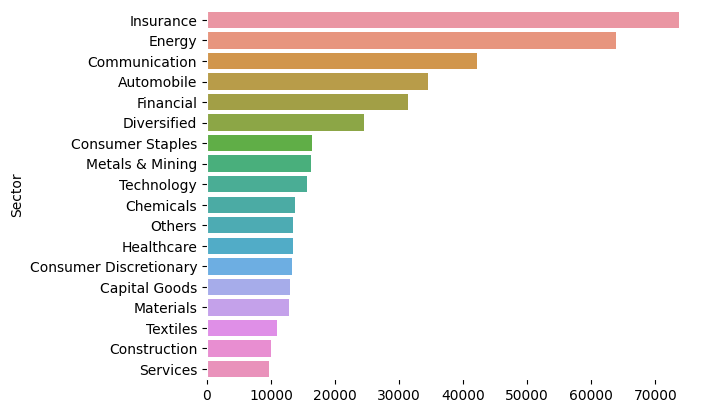

In [67]:
BSE_DATA['Enterprise Value(Cr)']=BSE_DATA['Enterprise Value(Cr)'].apply(only_nums)
median_of_sectors=BSE_DATA[['Sector','Enterprise Value(Cr)']].groupby('Sector').median()
s=median_of_sectors['Enterprise Value(Cr)'].sort_values(ascending=False)

sns.barplot(y=s.index,x=s.values)
plt.show()

# Is There any Relation between Dividend Per Share with Market Cap(Cr)

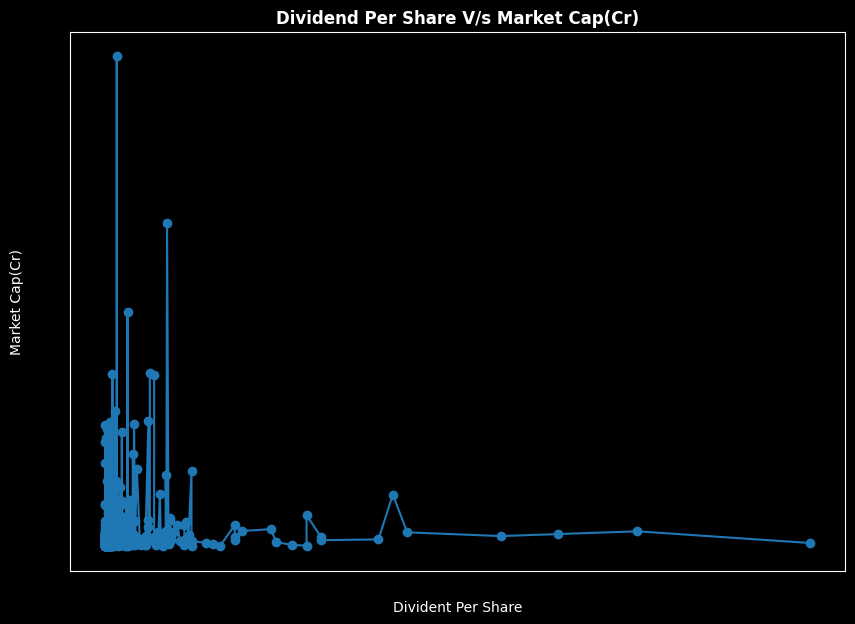

In [68]:
BSE_DATA['Dividend Per Share']=BSE_DATA['Dividend Per Share'].apply(only_nums)
plt.figure(figsize=(10,7),edgecolor='white',facecolor='black')
ax=plt.axes()
ax.set_facecolor('black')
plt.scatter(BSE_DATA['Dividend Per Share'],BSE_DATA['Market Cap(Cr)'])
plt.plot(BSE_DATA['Dividend Per Share'],BSE_DATA['Market Cap(Cr)'])
plt.rcParams['axes.edgecolor'] = 'white'
plt.xlabel('Divident Per Share',color='white')
plt.ylabel('Market Cap(Cr)',color='white')
plt.title('Dividend Per Share V/s Market Cap(Cr)', fontweight='bold',color='white')
plt.show()

<!-- Companies in different Industry with positive and negative 3-Year Return -->

# Industry With Positive 3-Year Return

In [69]:
BSE_DATA['3-Year Return']

0       0.16
1      41.31
2      11.82
3      24.18
4       9.51
       ...  
496    32.95
497     4.16
498   -34.57
499         
500    65.83
Name: 3-Year Return, Length: 501, dtype: object

In [82]:
Best_industry_with_3_years_return = BSE_DATA[['Industry','Company','3-Year Return']]
Best_industry_with_3_years_return['3-Year Return']=Best_industry_with_3_years_return['3-Year Return'].apply(only_nums)  #--- Making data graph compactible;

lis=[]
for n, ele in enumerate(Best_industry_with_3_years_return['3-Year Return']):
    if ele>0:
        lis.append('+ve')
    else:
        lis.append('-ve')

Best_industry_with_3_years_return['Positive/Negative']=lis
Best_industry_with_3_years_return=Best_industry_with_3_years_return[['Industry','Positive/Negative']]
Best_industry_with_3_years_return=Best_industry_with_3_years_return[Best_industry_with_3_years_return['Positive/Negative']=='+ve']
Best_industry_with_3_years_return=Best_industry_with_3_years_return.groupby('Industry').count()['Positive/Negative'].sort_values(ascending=False) #--- Making data graph compactible;
Best_industry_with_3_years_return=Best_industry_with_3_years_return.head(15)

C:\Users\bjami\AppData\Local\Temp\ipykernel_1080\2480299111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Best_industry_with_3_years_return['3-Year Return']=Best_industry_with_3_years_return['3-Year Return'].apply(only_nums)  #--- Making data graph compactible;
C:\Users\bjami\AppData\Local\Temp\ipykernel_1080\2480299111.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Best_industry_with_3_years_return['Positive/Negative']=lis


The real plot

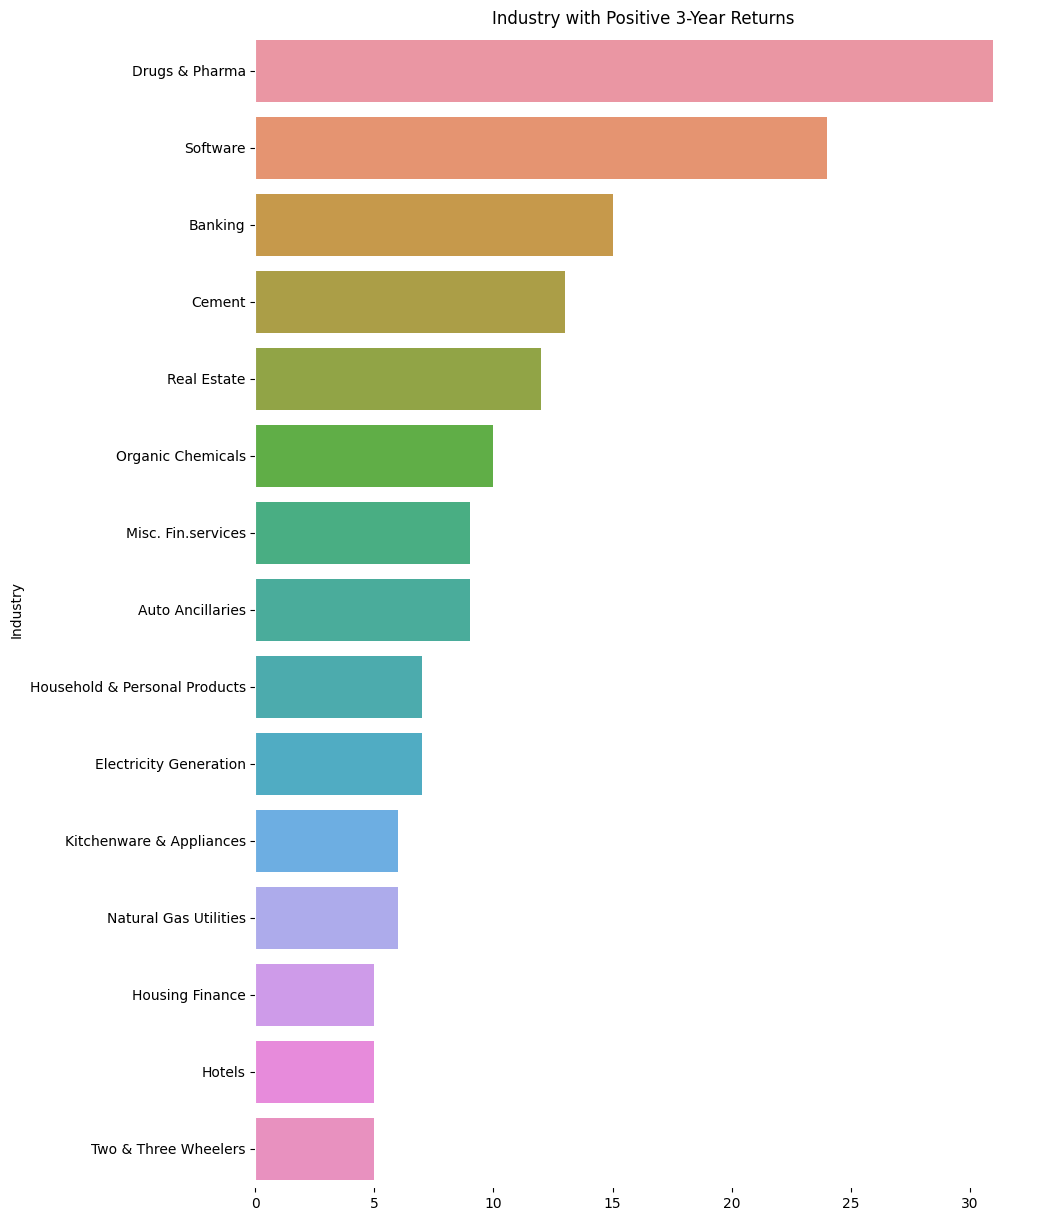

In [81]:
plt.figure(figsize=(10,15))
sns.barplot(x=Best_industry_with_3_years_return.values, y=Best_industry_with_3_years_return.index)
plt.title('Industry with Positive 3-Year Returns')
plt.show()

Best KPI for selecting best company stock

In [72]:
# There were 18 distinct sectors
# In each sector there are many companies
# KPI is Key Performance Indicator
# There are many KPI's than can decide the best stock in each sector like EV / EBITDA,Price to Earnings,
# Dividend Per Share,Price earnings to growth,Price to Book etc.
#  We choose our KPI as Price to Earnings
# Price to Earnings = share price/earning per share
# We thought that if earning per share is more means companies are doing a good business. They have works,projects
# ,market in their control.
# So higher is earning per share, lesser will be Price to Earnings and hence
# company with least Price to Earnings will be the best stock of that sector.


Top 10 Company with Highest PE Ratio

In [ ]:
BSE_DATA['Price to Earnings']=BSE_DATA['Price to Earnings'].apply(only_nums)
Company_with_best_PE = BSE_DATA[['Company','Price to Earnings']].sort_values(by='Price to Earnings', ascending=False).head(10)
Company_with_best_PE

<AxesSubplot:xlabel='Price to Earnings', ylabel='Company'>

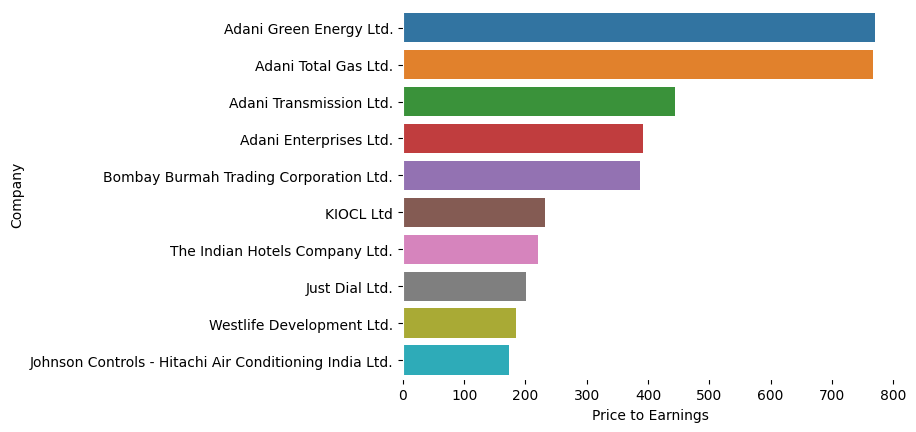

In [84]:
sns.barplot(x=Company_with_best_PE['Price to Earnings'],y=Company_with_best_PE.Company)

In [76]:
# ISIN: An International Securities Identification Number (ISIN) is a 12-digit alphanumeric code
#  that uniquely identifies a specific security.
#  The organization that allocates ISINs in any particular country is the country's respective
#  National Numbering Agency (NNA).

In [77]:
# Enterprise value: is the total value of a company including the companies total markert market
#  capital and its net debt;
# Market capital is the total price of outstanding shares of a company in the market;
#  Its calculated by multiplying total outstanding shares * its each shares price in the stock market;